In [1]:
#spark.stop()

In [28]:
import os, sys
import datetime as dt
DEVEL_SRC = os.path.join(os.environ.get('BDA_USER_HOME', ''), "src", "devel")
if DEVEL_SRC not in sys.path:
    sys.path.append(DEVEL_SRC)

USECASES_SRC = os.path.join(DEVEL_SRC, "use-cases") # TODO when - is removed, remove also this line and adapt imports
if USECASES_SRC not in sys.path: 
    sys.path.append(USECASES_SRC)
    
AMDOCS_SRC = os.path.join(DEVEL_SRC, "amdocs_informational_dataset") # TODO when - is removed, remove also this line and adapt imports
if AMDOCS_SRC not in sys.path: 
    sys.path.append(AMDOCS_SRC)
    
import pykhaos.utils.custom_logger as clogger
logging_file = os.path.join(os.environ.get('BDA_USER_HOME', ''), "logging",
                                    "out_" + dt.datetime.now().strftime("%Y%m%d_%H%M%S") + ".log")
logger = clogger.configure_logger(log_filename=logging_file, std_channel=sys.stderr, logger_name="")
logger.info("Logging to file {}".format(logging_file))    
    
    
from project.project_generic import Project


import pykhaos.utils.notebooks as nb

#project_obj = Project("CCC_model_nb", "CCC_model_pykhaos_nb")   

import time
start_time = time.time()
app_name = "CCC_model_nb"

import pykhaos.utils.pyspark_configuration as pyspark_config
sc, spark, sql_context = pyspark_config.get_spark_session(app_name=app_name, log_level="OFF", min_n_executors = 1, max_n_executors = 10, n_cores = 4,
                         executor_memory = "16g", driver_memory="16g")
print("Ended spark session: {} secs | default parallelism={}".format(time.time() - start_time,
                                                                     sc.defaultParallelism))


RUNNING_FROM_NOTEBOOK = nb.isnotebook()
import matplotlib.pyplot as plt
if RUNNING_FROM_NOTEBOOK:
    %load_ext autoreload
    %autoreload 2
    %matplotlib inline  
    EXTERNAL_LIB = os.path.join(os.environ.get('BDA_USER_HOME', ''), "lib", "external_libs")
    if EXTERNAL_LIB not in sys.path:
        sys.path.append(EXTERNAL_LIB)
    %load_ext jupyternotify
    


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

20181221-125803 [INFO ] Logging to file /var/SP/data/home/csanc109/logging/out_20181221_125803.log


Ended spark session: 0.0388650894165 secs | default parallelism=4
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [3]:
from amdocs_informational_dataset.engine.call_centre_calls import CallCentreCalls
from pyspark.sql.functions import collect_set, concat, size, coalesce, col, lpad, struct, count as sql_count, lit, min as sql_min, max as sql_max, collect_list, udf, when
from pyspark.sql.types import StringType, ArrayType, MapType, StructType, StructField, IntegerType
from pyspark.sql.functions import array, regexp_extract
sys.path.append(os.path.join(os.environ.get('BDA_USER_HOME', ''), "src", "devel", "pykhaos", "external_lib"))


In [4]:
import pykhaos.utils.notebooks as nb


# In[2]:

import json
RUNNING_FROM_NOTEBOOK = nb.isnotebook()

CCC_TRAIN_TEST_YAML = os.path.join(USECASES_SRC, "churn", "models", "ccc", "input", "ccc_train_test.yaml")

import yaml
input_data = yaml.load(open(CCC_TRAIN_TEST_YAML))

UNIVARIATE_ANALYSIS = 'univariate'
TRAIN_MODEL = 'train'
SCORE_NEW_DATA = 'score'
MAJOR_VERSION = '0'
MINOR_VERSION = '003'
phase =  TRAIN_MODEL #  UNIVARIATE_ANALYSIS # this parameters must be read as a program argument.
phase = phase.lower()     

# from pykhaos.modeling.model_info import ModelInfo
# from pykhaos.reporting.reporter import Reporter
# from pykhaos.reporting.type.univariate import Univariate
# from pykhaos.reporting.writter.pdf_writter import PDFWritter
# from pykhaos.reporting.utils.measures import completness


In [5]:
# Launch from console 
#/usr/bin/java -ea -verbose:gc -XX:+PrintGCDetails -XX:+PrintGCTimeStamps -cp /var/SP/data/home/csanc109/lib/external_libs/h2o/backend/bin/h2o.jar water.H2OApp -ip 127.0.0.1 -baseport 54323 -ice_root /tmp/tmpMKtqxt -name H2O_from_python_csanc109_5suywz -log_level INFO

# from lib.external_libs import h2o
# h2o.__version__
# h2o.init(ip="127.0.0.1", port=54323, strict_version_check=False)

#######################################
# H2O
#######################################

MODEL_NAME = "ccc_pykhaos"
from pykhaos.modeling.model import Model

from pykhaos.modeling.h2o.h2o_functions import restart_cluster_loop
restart_cluster_loop(port=54127)


Using h2o version 3.18.0.10
('HOLAAAAA', <logging.RootLogger object at 0x7f5589a10790>)
Using h2o version 3.18.0.10
Shutdown 3.18.0.10
init 3.18.0.10
Checking whether there is an H2O instance running at http://localhost:54127. connected.


H2O cluster uptime:,12 mins 10 secs
H2O cluster timezone:,Europe/Rome
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.10
H2O cluster version age:,6 months and 28 days !!!
H2O cluster name:,H2O_from_python_csanc109_fit1vp
H2O cluster total nodes:,1
H2O cluster free memory:,8.97 Gb
H2O cluster total cores:,56
H2O cluster allowed cores:,56
H2O cluster status:,"locked, healthy"


Done!
locked=True healthy=True
Shutdown 3.18.0.10
H2O session _sid_b4dd closed.
init 3.18.0.10
Checking whether there is an H2O instance running at http://localhost:54127. connected.


H2O cluster uptime:,13 mins 10 secs
H2O cluster timezone:,Europe/Rome
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.10
H2O cluster version age:,6 months and 28 days !!!
H2O cluster name:,H2O_from_python_csanc109_fit1vp
H2O cluster total nodes:,1
H2O cluster free memory:,8.97 Gb
H2O cluster total cores:,56
H2O cluster allowed cores:,56
H2O cluster status:,"locked, healthy"


Done!
locked=True healthy=True
Shutdown 3.18.0.10
init 3.18.0.10
Checking whether there is an H2O instance running at http://localhost:54127..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.7.0_79"; Java(TM) SE Runtime Environment (build 1.7.0_79-b15); Java HotSpot(TM) 64-Bit Server VM (build 24.79-b02, mixed mode)
  Starting server from /opt/cloudera/parcels/Anaconda-2.5.0/lib/python2.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpWUdUQo
  JVM stdout: /tmp/tmpWUdUQo/h2o_csanc109_started_from_python.out
  JVM stderr: /tmp/tmpWUdUQo/h2o_csanc109_started_from_python.err
  Server is running at http://127.0.0.1:54127
Connecting to H2O server at http://127.0.0.1:54127... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Rome
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.10
H2O cluster version age:,6 months and 28 days !!!
H2O cluster name:,H2O_from_python_csanc109_jy0y3n
H2O cluster total nodes:,1
H2O cluster free memory:,12.44 Gb
H2O cluster total cores:,56
H2O cluster allowed cores:,56
H2O cluster status:,"accepting new members, healthy"


Done!
locked=False healthy=True
out of while


In [6]:
# v1 df = h2o.import_file("hdfs://vgddp350hr.dc.sedc.internal.vodafone.com/data/udf/vf_es/churn/ccc_model/comercial/df_20180501_20180531_c20180430_n60_comercial_msisdn/1544614716.csv")
# v2 df = h2o.import_file("hdfs://vgddp350hr.dc.sedc.internal.vodafone.com/data/udf/vf_es/churn/ccc_model/comercial/df_20180501_20180531_c20180430_n60_comercial_msisdn/1544755879.csv")
# v3
#df = h2o.import_file("hdfs://vgddp350hr.dc.sedc.internal.vodafone.com/data/udf/vf_es/churn/ccc_model/comercial/df_20180501_20180531_c20180430_n60_comercial_msisdn_OLD/1544818058.csv")


In [38]:
df_tar = spark.read.option("delimiter", "|").option("header", True).csv('/data/udf/vf_es/churn/ccc_model/comercial/df_20180501_20180531_c20180430_n60_comercial_msisdn_OLD')
# # df_tar.select("PRICE_DATA").distinct().show()

repl_chars = {
               "á" : "a",
               "í" : "i",
               "ñ" : "n",  
               "ó" : "o",
               "é" : "e"
 }

cities = {"lava$" : "alava",
          "^ja.n$" : "jaen", 
          "guip.*oa" : "guipozcoa",
          "espa.a" : "espana",
          "logro.o" : "logrono",
          "coru.* (la)" : "a coruna",
          'A CORU<0xEFBFBD>A' : 'A CORUNA',
          "ALICANTE/ALACANT" : "ALICANTE",
          'A CORU?A' : 'A CORUNA',
          'A CORU\xc3\x91A' : 'A CORUNA',
          'A Coru<0xEFBFBD>a' : 'A CORUNA',
          'A Coru\xc3\xb1a' : 'A CORUNA',
          'CORUOA (LA)' : 'A CORUNA',
          "S/C  TENERIFE" : "S.C. TENERIFE"}

from pyspark.sql.functions import regexp_replace, col, countDistinct, upper, translate, lower

df_tar = df_tar.withColumn("DIR_FACTURA4_MOLA", lower(col("DIR_FACTURA4") ))
for k,v in repl_chars.items():
    df_tar = df_tar.withColumn("DIR_FACTURA4_MOLA", translate(col("DIR_FACTURA4_MOLA"), ("(?i)"+k).lower(), v.lower())) 

for k,v in cities.items():
    df_tar = df_tar.withColumn("DIR_FACTURA4_MOLA", regexp_replace(col("DIR_FACTURA4_MOLA"), k, v)) 
            
df_tar.select('DIR_FACTURA4_MOLA').distinct().show(50,False)
# #df_tar.agg(countDistinct(col("DIR_FACTURA4_MOLA")).alias("count")).show()

+-----------------------------+
|DIR_FACTURA4_MOLA            |
+-----------------------------+
|...                          |
|bzkaa                        |
|elche                        |
|madrt                        |
|huelva                       |
|polgono ndustral de santa col|
|algecras                     |
|albacete                     |
|castelln                     |
|slas baleares                |
|a coru�a                     |
|castlla la mancha            |
|toledo                       |
|espaa                        |
|c�dz                         |
|cdz                          |
|ourense                      |
|madrd-espaa                  |
|granada-espaa                |
|gran canara                  |
|c. real                      |
|avla- espaa                  |
|alcante-espaa                |
|el palmar, murca             |
|barcelona- espaa             |
|grona                        |
|s/c  tenerfe                 |
|ceuta                        |
|barros 

In [8]:
%%notify -m "CCC_model_pykahos: ended CCCdata "
#from churn.config_manager.ccc_model_config_mgr import  CCCmodelConfig
#config_obj = CCCmodelConfig('/var/SP/data/home/csanc109/src/devel/use-cases/churn/input/dp_ccc_model.yaml')
print("Starting CCC categories data")
from churn.models.ccc.data.ccc_data import  CCC_Data
data_abs_data_obj = CCC_Data(input_data=None, filename="/data/udf/vf_es/churn/ccc_model/comercial/df_20180501_20180531_c20180430_n60_comercial_msisdn_OLD", pkey_cols=["msisdn"])
print("Ended CCC_Data")

Starting CCC categories data


/var/SP/data/home/csanc109/src/devel/pykhaos/reporting/utils/plots.py:13: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/opt/cloudera/parcels/Anaconda/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/opt/cloudera/parcels/Anaconda/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/opt/cloudera/parcels/Anaconda-2.5.0/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/cloudera/parcels/Anaconda/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/cloudera/parcels/Anaconda/lib/python2.7

!!!!!!! HARD CODED !!!!!!!!!!
'/data/udf/vf_es/churn/ccc_model/comercial/df_20180501_20180531_c20180430_n60_comercial_msisdn_OLD' no existe
Found /data/udf/vf_es/churn/ccc_model/comercial/df_20180501_20180531_c20180430_n60_comercial_msisdn_OLD. Loading...
set_h2o_training_data - filename /data/udf/vf_es/churn/ccc_model/comercial/df_20180501_20180531_c20180430_n60_comercial_msisdn_OLD


20181220-193359 [INFO ] ***** locked=False healthy=True
20181220-193359 [INFO ] Trying to import '/data/udf/vf_es/churn/ccc_model/comercial/df_20180501_20180531_c20180430_n60_comercial_msisdn_OLD' hdfs=True parquet=False
20181220-193401 [INFO ] Trying to import hdfs://vgddp349hr.dc.sedc.internal.vodafone.com/data/udf/vf_es/churn/ccc_model/comercial/df_20180501_20180531_c20180430_n60_comercial_msisdn_OLD
20181220-193405 [ERROR] file hdfs://vgddp349hr.dc.sedc.internal.vodafone.com/data/udf/vf_es/churn/ccc_model/comercial/df_20180501_20180531_c20180430_n60_comercial_msisdn_OLD could not be found at node 0


HTTP 500 Server Error:
Server error water.api.HDFSIOException:
  Error: HDFS IO Failure: 
 accessed URI : hdfs://vgddp349hr.dc.sedc.internal.vodafone.com/data/udf/vf_es/churn/ccc_model/comercial/df_20180501_20180531_c20180430_n60_comercial_msisdn_OLD
 configuration: Configuration: core-default.xml, core-site.xml, mapred-default.xml, mapred-site.xml, yarn-default.xml, yarn-site.xml, hdfs-default.xml, hdfs-site.xml, /opt/cloudera/parcels/SPARK2/lib/spark2/conf/yarn-conf/core-site.xml
 org.apache.hadoop.ipc.RemoteException(org.apache.hadoop.ipc.StandbyException): Operation category READ is not supported in state standby. Visit https://s.apache.org/sbnn-error
	at org.apache.hadoop.hdfs.server.namenode.ha.StandbyState.checkOperation(StandbyState.java:88)
	at org.apache.hadoop.hdfs.server.namenode.NameNode$NameNodeHAContext.checkOperation(NameNode.java:1835)
	at org.apache.hadoop.hdfs.server.namenode.FSNamesystem.checkOperation(FSNamesystem.java:1515)
	at org.apache.hadoop.hdfs.server.nameno

20181220-193405 [INFO ] Trying to import hdfs://vgddp350hr.dc.sedc.internal.vodafone.com/data/udf/vf_es/churn/ccc_model/comercial/df_20180501_20180531_c20180430_n60_comercial_msisdn_OLD


Parse progress: |█████████████████████████████████████████████████████████| 100%


20181220-193417 [INFO ] file hdfs://vgddp350hr.dc.sedc.internal.vodafone.com/data/udf/vf_es/churn/ccc_model/comercial/df_20180501_20180531_c20180430_n60_comercial_msisdn_OLD found at node 1


file hdfs://vgddp350hr.dc.sedc.internal.vodafone.com/data/udf/vf_es/churn/ccc_model/comercial/df_20180501_20180531_c20180430_n60_comercial_msisdn_OLD found at node 1
Preparing __prepare_ccc_data_for_h2o
Not possible to delete portout_date. Col does not exist
Imputing -1 ... 
Imputing 0 ... 
Imputing unknown ... 
col COMERCIAL does not exist
col NO_COMERCIAL does not exist
col PRECIO does not exist
col TERMINAL does not exist
col CONTENIDOS does not exist
col SERVICIO/ATENCION does not exist
col TECNICO does not exist
col BILLING does not exist
col FRAUD does not exist
col NO_PROB does not exist
col TOTAL_COMERCIAL does not exist
col TOTAL_NO_COMERCIAL does not exist
col fx_tv_fx_first_nif does not exist
col mobile_fx_first_nif does not exist
col tv_fx_first_nif does not exist
col prepaid_fx_first_nif does not exist
col bam_mobile_fx_first_nif does not exist
col fixed_fx_first_nif does not exist
col bam_fx_first_nif does not exist
col fbb_fx_first_nif does not exist


20181220-193845 [INFO ] df_h2o ready to be used!


Ended CCC_Data


<IPython.core.display.Javascript object>

In [9]:
%%notify -m "CCC_model_pykahos: ended fit "
xlsx_report_template_path = os.path.join(USECASES_SRC, "churn", "models", "ccc", 'input', 'xlsx_report_template.yaml')
model_yaml_path = os.path.join(USECASES_SRC, "churn", "models", 'ccc', 'input', 'h2o_automl.yaml')
model_name = MODEL_NAME+'_model'

modeler = Model(model_name, model_yaml_path)
modeler.fit(data_abs_data_obj)

loaded '/var/SP/data/home/csanc109/src/devel/use-cases/churn/models/ccc/input/h2o_automl.yaml'
splitting ... 
<class 'h2o.frame.H2OFrame'>
<class 'h2o.frame.H2OFrame'>
H2O Engine :)
Using h2o version 3.18.0.10
**** FIT *****
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
Could not find exact threshold 0.3; using closest threshold found 0.299134482512.
Could not find exact threshold 0.5; using closest threshold found 0.49940081983.
Could not find exact threshold 0.7; using closest threshold found 0.699889377513.
Could not find exact threshold 0.3; using closest threshold found 0.299134482512.
Could not find exact threshold 0.5; using closest threshold found 0.49940081983.
Could not find exact threshold 0.7; using closest threshold found 0.699889377513.
Could not find exact threshold 0.3; using 

<IPython.core.display.Javascript object>

# SAVE model

In [10]:
%%notify -o
result="FAILED"
save_model_path = os.path.join(os.environ.get('BDA_USER_HOME', ''), "data", "churn", "ccc", "results",  '{}_model_2'.format(MODEL_NAME))
modeler.save(save_model_path)
result="OK"
"CCC_model_pykahos: [{}] model saved ".format(result)

************** model.py save
['model_fit_config', 'numero_variables', 'target_freq', 'model train metrics', 'model test metrics', 'test_partition_size', 'train_partition_size']
Starting save of model at '/var/SP/data/home/csanc109/data/churn/ccc/results/ccc_pykhaos_model_2/ccc_pykhaos_model.pkl'
Saving object at /var/SP/data/home/csanc109/data/churn/ccc/results/ccc_pykhaos_model_2/ccc_pykhaos_model.pkl
Calling to __getstate model
saving_model_info
['model_fit_config', 'numero_variables', 'target_freq', 'model train metrics', 'model test metrics', 'test_partition_size', 'train_partition_size']
 *********** model.py save REMOVEEEEEEEEEE !!!!!!!!
Calling to __getstate H2O Factory
['config', 'params', 'modeler', 'feature_importance']
['config', 'params', 'feature_importance']
---
Model object saved succesfully in file '/var/SP/data/home/csanc109/data/churn/ccc/results/ccc_pykhaos_model_2/ccc_pykhaos_model.pkl'


'CCC_model_pykahos: [OK] model saved '

<IPython.core.display.Javascript object>

# Reporter

In [11]:
%%notify -o
result="FAILED"

from pykhaos.reporting.reporter import Reporter
print("HOLA")

reporter = (Reporter(model_name, save_model_path, xlsx_report_template_path)
     .set_saving_path(os.path.join(os.environ.get('BDA_USER_HOME', ''), "data", "churn", "ccc", "results"))
     #.set_extra_info(CCC_TRAIN_TEST_YAML)
           )
reporter.create()

print 'Informe generado!'

result="OK"
"CCC_model_pykahos: [{}] reporter finished".format(result)

HOLA
Reporter __init__ model_id=ccc_pykhaos_model model_dir=/var/SP/data/home/csanc109/data/churn/ccc/results/ccc_pykhaos_model_2 template_yaml_path=/var/SP/data/home/csanc109/src/devel/use-cases/churn/models/ccc/input/xlsx_report_template.yaml
Loading model /var/SP/data/home/csanc109/data/churn/ccc/results/ccc_pykhaos_model_2/ccc_pykhaos_model.pkl
Loading object from /var/SP/data/home/csanc109/data/churn/ccc/results/ccc_pykhaos_model_2/ccc_pykhaos_model.pkl
Calling to __setstate H2O Factory
['params', 'config', 'feature_importance']
<type 'NoneType'>
Calling to __setstate in model
['_Model__model_id', '_Model__model', 'model_info', '_Model__config', '_Model__model_info', 'model', '_Model__yaml_filename']
{'_Model__config': {'engine': 'h2o',
                    'intro': True,
                    'params': {'balance_classes': True,
                               'max_runtime_secs': 30},
                    'type': 'DRF'},
 '_Model__model': <pykhaos.modeling.factory.h2o_factory.H2OFactor

20181220-194028 [DEBUG] STREAM IHDR 16 13
20181220-194028 [DEBUG] STREAM sBIT 41 4
20181220-194028 [DEBUG] sBIT 41 4 (unknown)
20181220-194028 [DEBUG] STREAM pHYs 57 9
20181220-194028 [DEBUG] STREAM tEXt 78 57
20181220-194028 [DEBUG] STREAM IDAT 147 8192


(720, 720)
Model
<class 'pandas.core.frame.DataFrame'>
sheet Train metrics
Train metrics
<type 'str'>
Train metrics
<class 'matplotlib.figure.Figure'>
******* sheet Train metrics


20181220-194028 [DEBUG] STREAM IHDR 16 13
20181220-194028 [DEBUG] STREAM sBIT 41 4
20181220-194028 [DEBUG] sBIT 41 4 (unknown)
20181220-194028 [DEBUG] STREAM pHYs 57 9
20181220-194028 [DEBUG] STREAM tEXt 78 57
20181220-194028 [DEBUG] STREAM IDAT 147 8192


(576, 576)
Train metrics
<type 'str'>
Train metrics
<class 'pandas.core.frame.DataFrame'>
Train metrics
<class 'matplotlib.figure.Figure'>
******* sheet Train metrics


20181220-194028 [DEBUG] STREAM IHDR 16 13
20181220-194028 [DEBUG] STREAM sBIT 41 4
20181220-194028 [DEBUG] sBIT 41 4 (unknown)
20181220-194028 [DEBUG] STREAM pHYs 57 9
20181220-194028 [DEBUG] STREAM tEXt 78 57
20181220-194028 [DEBUG] STREAM IDAT 147 8192


(576, 360)
Train metrics
<class 'matplotlib.figure.Figure'>
******* sheet Train metrics


20181220-194028 [DEBUG] STREAM IHDR 16 13
20181220-194028 [DEBUG] STREAM sBIT 41 4
20181220-194028 [DEBUG] sBIT 41 4 (unknown)
20181220-194028 [DEBUG] STREAM pHYs 57 9
20181220-194028 [DEBUG] STREAM tEXt 78 57
20181220-194028 [DEBUG] STREAM IDAT 147 8192


(576, 360)
sheet Test metrics
Test metrics
<type 'str'>
Test metrics
<class 'matplotlib.figure.Figure'>
******* sheet Test metrics


20181220-194028 [DEBUG] STREAM IHDR 16 13
20181220-194028 [DEBUG] STREAM sBIT 41 4
20181220-194028 [DEBUG] sBIT 41 4 (unknown)
20181220-194028 [DEBUG] STREAM pHYs 57 9
20181220-194028 [DEBUG] STREAM tEXt 78 57
20181220-194028 [DEBUG] STREAM IDAT 147 8192


(576, 576)
Saved in '/var/SP/data/home/csanc109/data/churn/ccc/results/ccc_pykhaos_model_20181220_194027.xlsx'
Informe generado!


'CCC_model_pykahos: [OK] reporter finished'

<IPython.core.display.Javascript object>

# PREDICTION

In [12]:
# #modeler = Model.load(MODEL_NAME+'_model')
# if input_data[YAML_PREDICT][YAML_DO_PREDICT]:
#     from churn.models.ccc.data.ccc_data import  CCC_Data
#     predict_ccc_data_obj = CCC_Data(filename="")
# print("Ended CCC_Data")
#     print("User wants to make predictions")
#     modeler.predict(predict_ccc_data_obj)
# else:
#     print("User does not want to make predictions")
    

# POST PROCESS ANALYSIS

In [13]:
data = data_abs_data_obj.data()
df_data = data.as_data_frame()
data.types

train = modeler.get_model_info().get("model train metrics")["scores"]
test = modeler.get_model_info().get("model test metrics")["scores"]

Asking for key 'model train metrics' in model info dict
Asking for key 'model test metrics' in model info dict


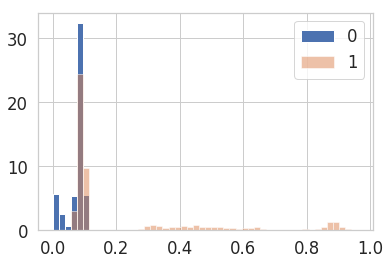

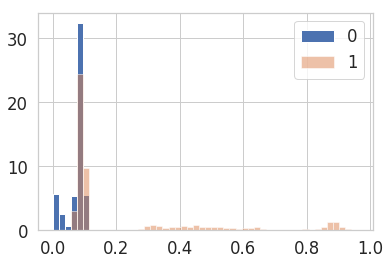

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline  

def show_hist(df):
    _, bins, _ = plt.hist(train[train["label"]==0]["SCORE"], bins=50, range=[0, train["SCORE"].max()], normed=True, label="0")
    _ = plt.hist(train[train["label"]==1]["SCORE"], bins=bins, alpha=0.5, normed=True, label="1")
    plt.legend()
    plt.show()

show_hist(train)
show_hist(test)

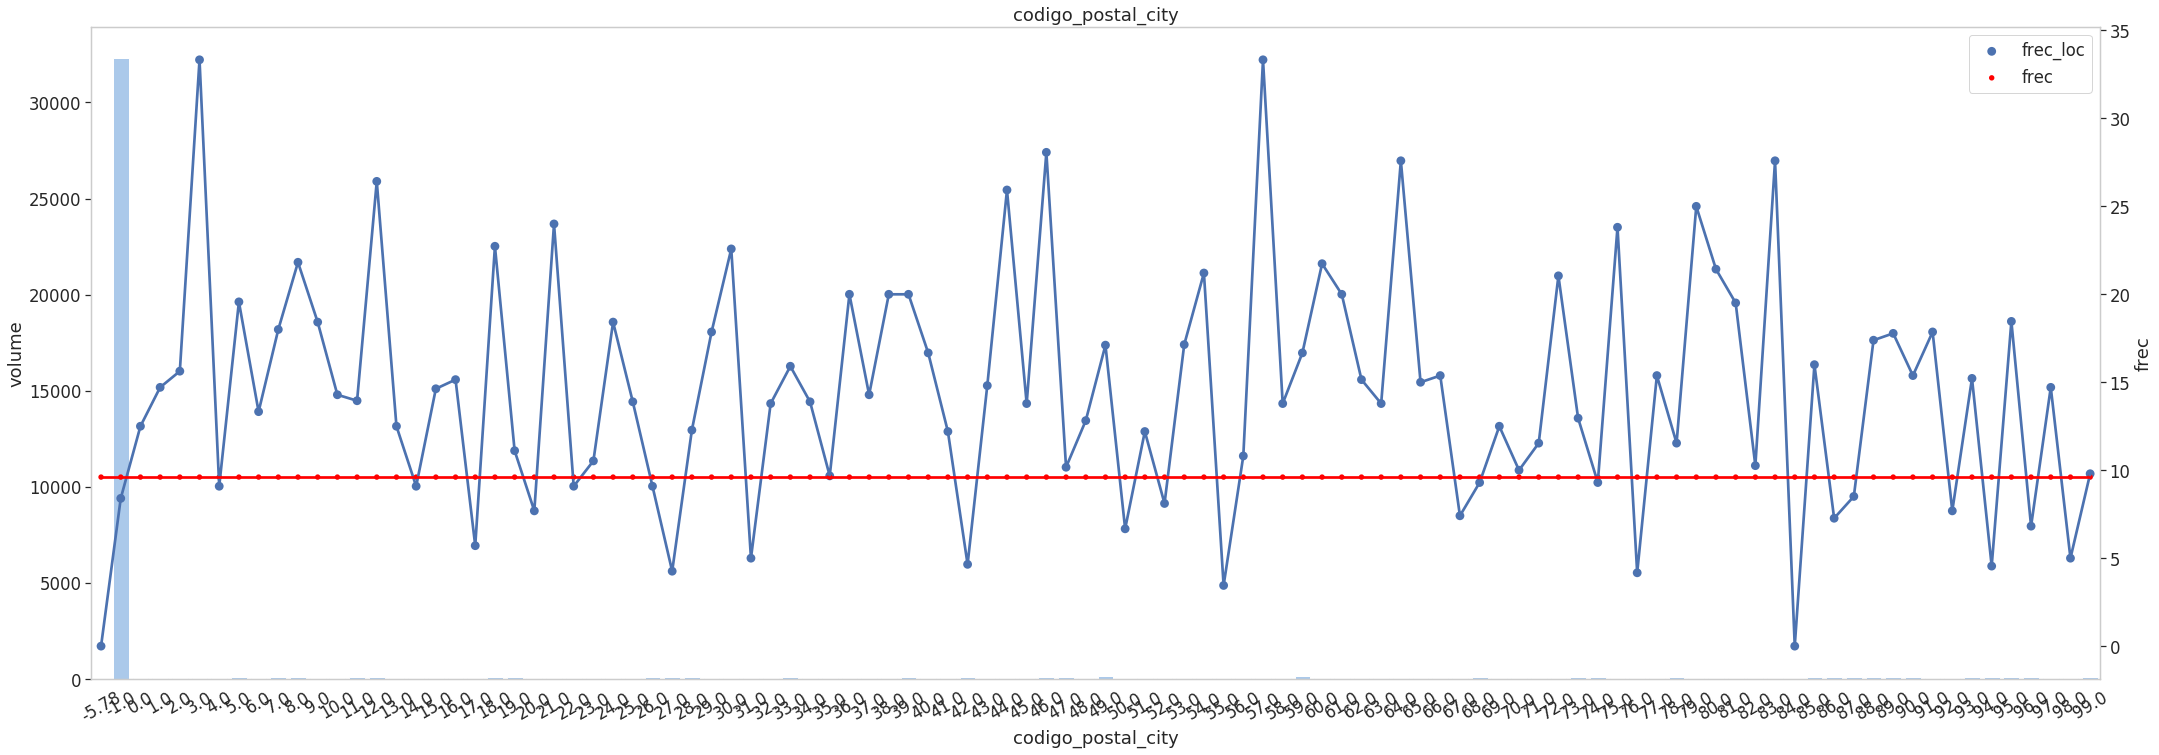

In [15]:
from pykhaos.reporting.utils.plots import univariate_analysis, univariate_hist
df_uni = univariate_analysis(df_data, "codigo_postal_city", target="label", sort=None)
univariate_hist(df_uni, "codigo_postal_city", sort = None)

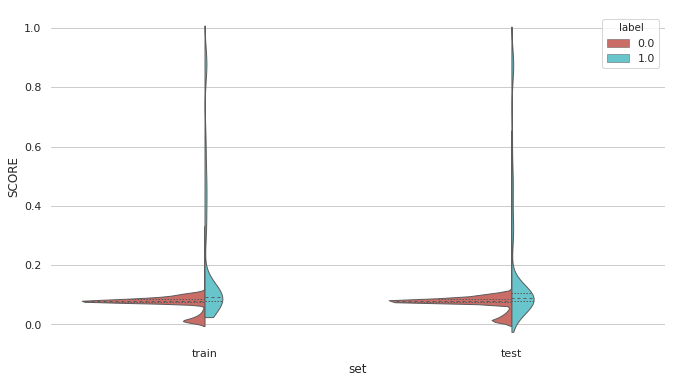

In [16]:
import pandas as pd
train["set"] = "train"
test["set"] = "test"
df = pd.concat([train, test])
# import matplotlib.pyplot as plt
# plt.switch_backend('agg')
from pykhaos.reporting.utils.plots import violin_distributions
_ = violin_distributions(df, x='set', y='SCORE', hue="label")

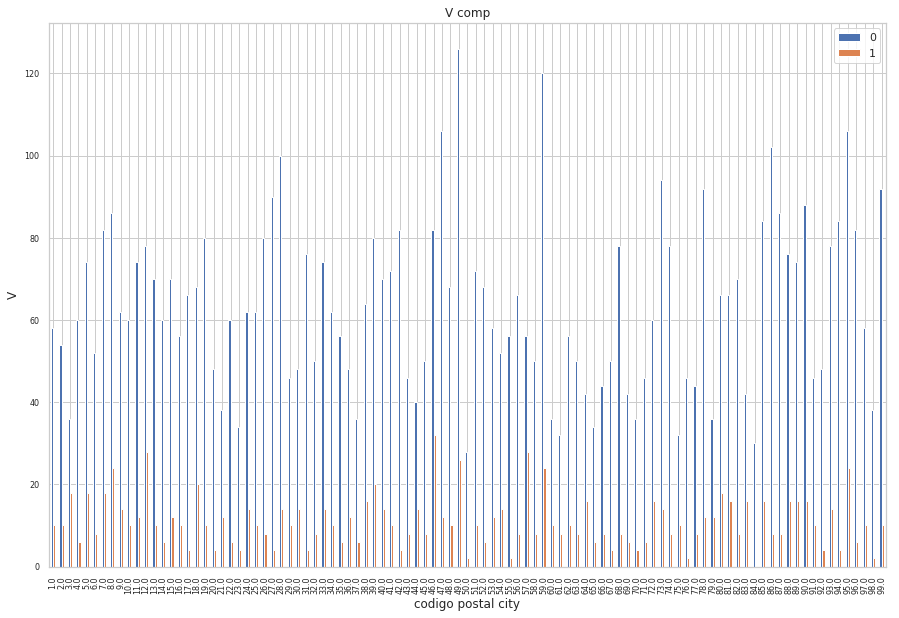

In [17]:
import numpy as np
df_ = df_data.copy()
#df_.reset_index(inplace=True)
#df_.set_index("codigo_postal_city", inplace=True)
df_ = df_[df_["codigo_postal_city"]>0]

df_pivot_label = pd.pivot_table(df_[["label", "codigo_postal_city"]], columns="label", index="codigo_postal_city", aggfunc=lambda x: len(x))
df_pivot_label.columns=["0", "1"]
import matplotlib.pyplot as plt
ax = df_pivot_label[['0','1']].plot(kind='bar', title ="V comp", figsize=(15, 10), legend=True, fontsize=8)
ax.set_xlabel("codigo postal city", fontsize=12)
ax.set_ylabel("V", fontsize=12)
plt.show()

In [18]:
var = ["codigo_postal_city"]
target = "label"
from sklearn.preprocessing import MinMaxScaler, Imputer

from sklearn.tree import DecisionTreeClassifier
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)

df_data = df_data[~df_data[target].isna()]

X = df_data[var].copy()
#X[var + "_NAN"] = X[var].isna().astype('int')
#X_imp = imp.fit_transform(X)
y = np.array(df_data[target])
dtree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=500)
dtree.fit(X_imp, y)

from pykhaos.reporting.utils.plots import prune

dtree_prune = prune(dtree)

from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,
                filled=True, rounded=True, feature_names=var,
                special_characters=True, rotate=True,
                class_names = ["NO_COMERCIAL", "COMERCIAL"],
                impurity=False, proportion=True, label='root')

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
filename = '/var/SP/data/home/csanc109/data/churn/ccc/results/graph_{}.png'.format(int(time.time()))
graph.write_png(filename)

# SHOW IMAGE FROM FILE
from IPython.display import display
from PIL import Image
display(Image.open(filename))

NameError: name 'X_imp' is not defined

# UNIVARIANT ANALYSIS

In [ ]:
import yaml
from pykhaos.reporting.type.univariate import Univariate
from churn.models.ccc.data.ccc_data import  CCC_Data

pdf_report_template_path = os.path.join(USECASES_SRC, "churn", "models", "ccc", 'input', 'univariante_template.yaml')

print 'univariant analysis: '
#periods = [201805, 201806, 201807]
default_filename = os.path.join(USECASES_SRC, "churn", "models", "ccc", "input", "ccc_train_test.yaml")
input_data = yaml.load(open(default_filename))
data_abs_data_obj = CCC_Data(input_data)
univariate_info = Univariate(data_abs_data_obj, MODEL_NAME+'_univariate').analysis()
univariate_info.save()
print 'end of analysis: {}'.format(MODEL_NAME+'_univariate')

print 'Generando informe: '
reporter = Reporter() \
    .set_model_info(ModelInfo.load(MODEL_NAME+'_univariate')) \
    .set_template('model/univariante.yaml')\
    .set_saving_path(os.path.join(os.environ.get('BDA_USER_HOME', ''), "data", "churn", "ccc", "results"))
reporter.create()
print 'Informe generado!'
